# Advanced Lane Lines

## Camera Calibration

In [1]:
import cv2
import os

cam_cal_data_dir = 'camera_cal'
cam_cal_images = os.listdir(cam_cal_data_dir)
num_images = len(cam_cal_images)
num_images

20

Draw all images into a 4x5 grid.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def BGR_2_RGB(bgr):
    rgb = np.zeros(bgr.shape, dtype=bgr.dtype)
    rgb[..., 0] = bgr[..., 2]
    rgb[..., 1] = bgr[..., 1]
    rgb[..., 2] = bgr[..., 0]
    return rgb

fig = plt.figure(figsize=(12, 9))
images = []
for i in range(num_images):
    ax = fig.add_subplot(4, 5, i+1)
    im = cv2.imread(os.path.join(cam_cal_data_dir, cam_cal_images[i]))
    ax.imshow(BGR_2_RGB(im))
    ax.set_title(cam_cal_images[i])
    images.append(im)

Detect chessboard corners

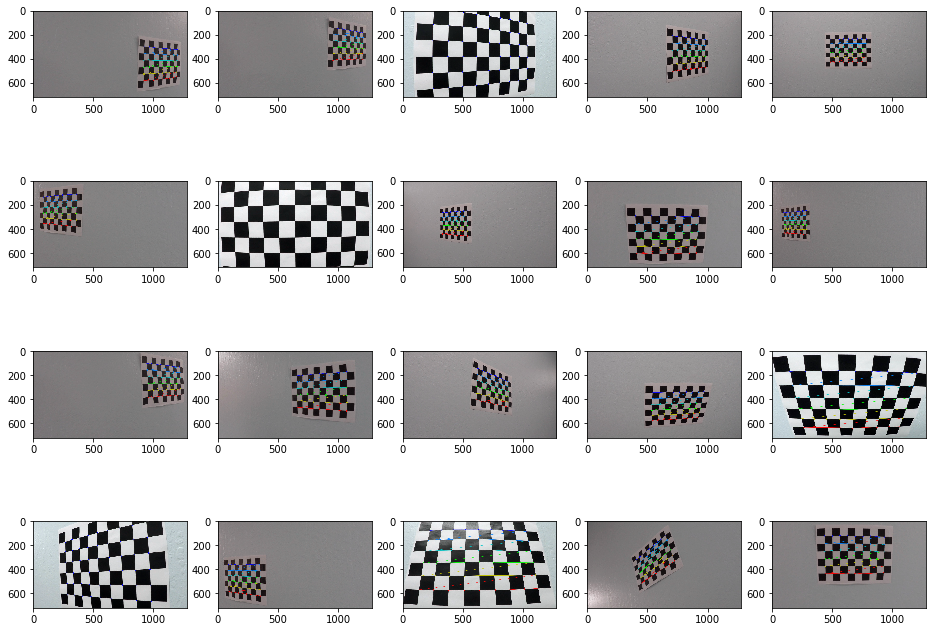

In [3]:
objpoints, imgpoints = [], []
objp = np.zeros((6 * 9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

fig = plt.figure(figsize=(16, 12))
for i in range(num_images):
    im = images[i]
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret:
        imgpoints.append(np.squeeze(corners))
        objpoints.append(objp)
    debug_im = cv2.drawChessboardCorners(im, (9, 6), corners, ret)
    ax = fig.add_subplot(4, 5, i+1)
    ax.imshow(debug_im)

Calibrate camera

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Test the camera calibration on the 7th image:

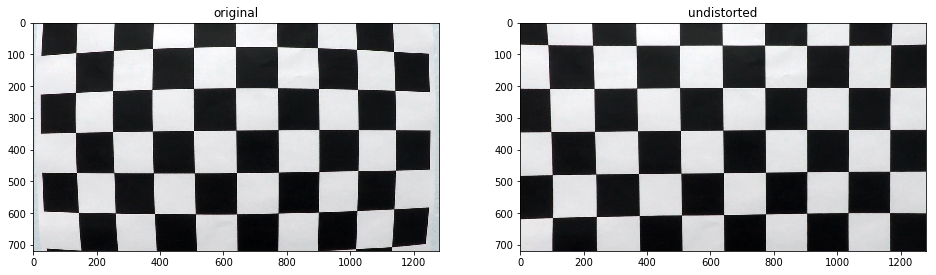

In [5]:
dst = cv2.undistort(images[6], mtx, dist, None, mtx)
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(images[6])
ax.set_title('original')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(dst)
ax.set_title('undistorted')

## Lane Detection Pipeline Development

Load a test image that contains yellow curved line.

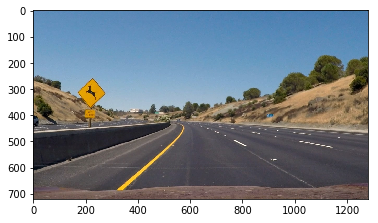

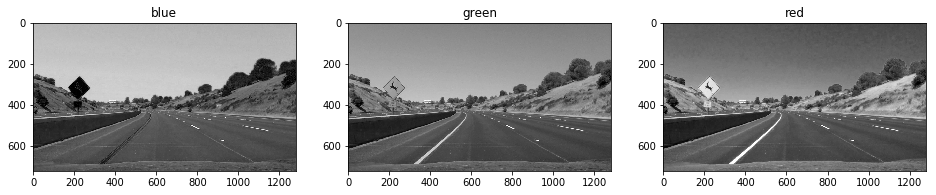

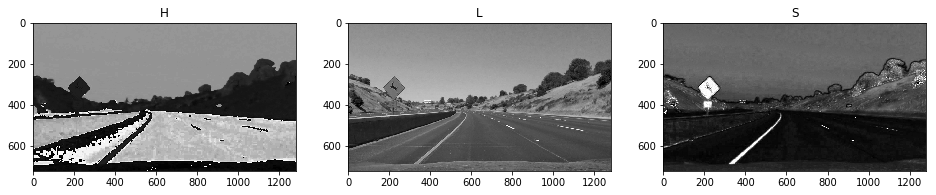

In [6]:
test_data_dir = 'test_images'
bgr = cv2.imread(os.path.join(test_data_dir, 'test2.jpg'), cv2.IMREAD_COLOR)
hls = cv2.cvtColor(bgr, cv2.COLOR_BGR2HLS)

def plot_3_channels(bgr, color_names=['blue', 'green', 'red']):
    fig = plt.figure(figsize=(16, 6))
    for i in range(3):
        ax = fig.add_subplot(1,3, i + 1)
        ax.imshow(bgr[..., i], cmap='gray')
        ax.set_title(color_names[i])

plt.imshow(BGR_2_RGB(bgr))
plot_3_channels(bgr)
plot_3_channels(hls, color_names=['H', 'L', 'S'])

### Finding a good thresholds for S

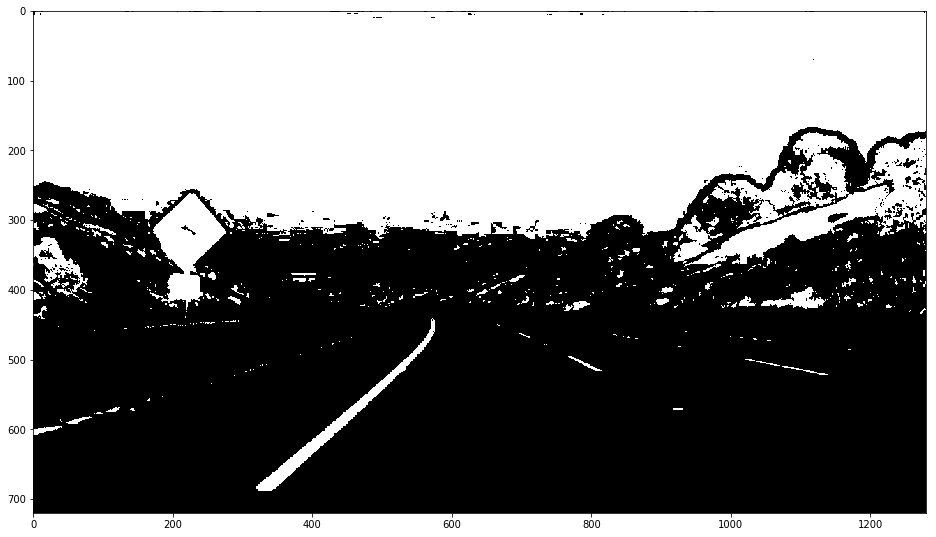

In [7]:
def color_threshold(bgr, thresh=(50, 255)):
    hls = cv2.cvtColor(bgr, cv2.COLOR_BGR2HLS)
    s_threshed = np.zeros((hls.shape[0], hls.shape[1]))
    s_threshed[(hls[..., 2] >= thresh[0]) & (hls[..., 2] <= thresh[1])] = 1
    s_threshed[(bgr[..., 0] >= 200) & (bgr[..., 1] >= 200) & (bgr[..., 2] >= 200)] = 1
    return s_threshed

s_threshed = color_threshold(bgr, thresh=(90, 255))
f, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(s_threshed, cmap='gray')

### Directional gradient thresholds

In [8]:
def gaussian_blur(gray, kernel=5):
    return cv2.GaussianBlur(gray, (kernel, kernel), 0)

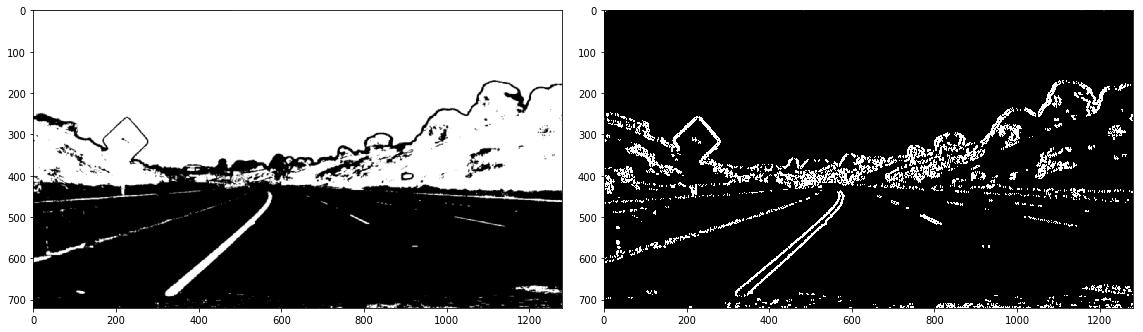

In [9]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=30):
    # Calculate directional gradient
    if orient == 'x':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    else:
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Apply threshold
    grad_binary = np.zeros_like(gray)
    grad_binary[(sobel >= thresh)] = 1
    return grad_binary


def mag_thresh(gray, sobel_kernel=3, mag_thresh=(20, 255)):
    # Calculate gradient magnitude
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    magnitude = np.absolute(sobelx) + np.absolute(sobely)
    # Apply threshold
    mag_binary = np.zeros_like(gray)
    mag_binary[(magnitude >= mag_thresh[0]) & (magnitude <= Mag_thresh[1])] = 1
    return mag_binary


def dir_threshold(gray, sobel_kernel=3, angle_thresh=(0, 1.2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    # The sobelx/y should not be both close to zero.
    binary_output[(absgraddir >= angle_thresh[0]) & (absgraddir <= angle_thresh[1])] = 1
    # Return the binary image
    return binary_output


def combined_sobel_threshold(gray, x_thresh=30, angle_thresh=(0, 1.3)):
    x_binary = abs_sobel_thresh(gray, thresh=x_thresh)
    dir_binary = dir_threshold(gray, angle_thresh=angle_thresh)
    combined = np.zeros_like(gray)
    combined[(x_binary == 1) & (dir_binary == 1)] = 1
    return combined


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
blurred_s_thresh = cv2.GaussianBlur(color_threshold(bgr) * 255, (5, 5), 0)
ax1.imshow(blurred_s_thresh, 'gray')
ax2.imshow(combined_sobel_threshold(blurred_s_thresh), 'gray')

### Perspective transformation

Use an straight line image and find a trapezoid.

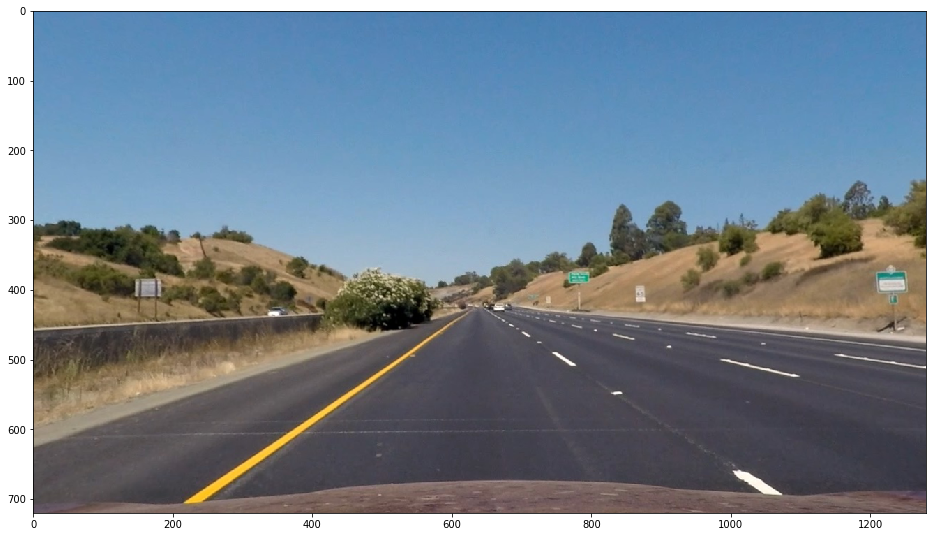

In [10]:
straight_image = cv2.imread(os.path.join(test_data_dir, 'straight_lines1.jpg'))
undistorted = cv2.undistort(straight_image, mtx, dist, None, mtx)
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(BGR_2_RGB(undistorted))

A good trapezoid seems to be [[0, 0], [0, 0], [0, 0], [0, 0]]

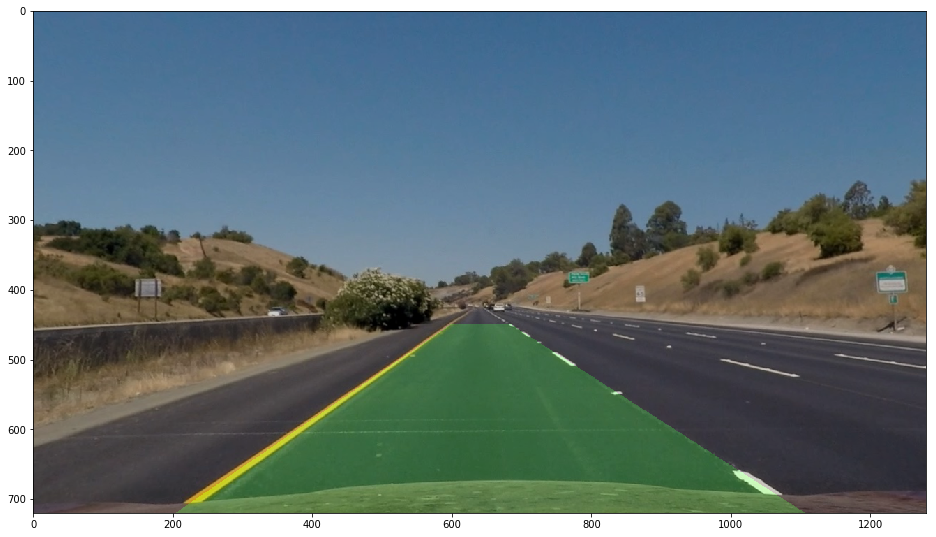

In [11]:
tpzd = [[600, 449], [683, 449], [1105, 719], [205, 719]]

def overlay_trapezoid(img, tpzd):
    trap = np.zeros_like(img)
    trap = cv2.fillPoly(trap, [np.array(tpzd)], [0, 255, 0])
    return (img * 0.8 + trap * 0.2).astype(np.uint8)

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(BGR_2_RGB(overlay_trapezoid(undistorted, tpzd)))

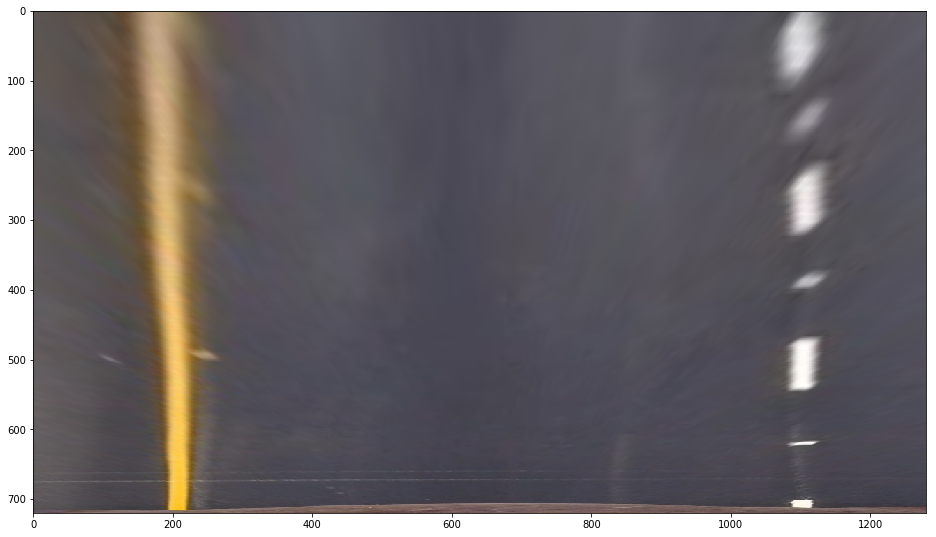

In [12]:
rect = [[205, 0], [1105, 0], [1105, 719], [205, 719]]
M = cv2.getPerspectiveTransform(np.float32(tpzd), np.float32(rect))
warped = cv2.warpPerspective(undistorted, M, (1280, 720), flags=cv2.INTER_LINEAR)
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(BGR_2_RGB(warped))

Perspective transform the thresholded image.

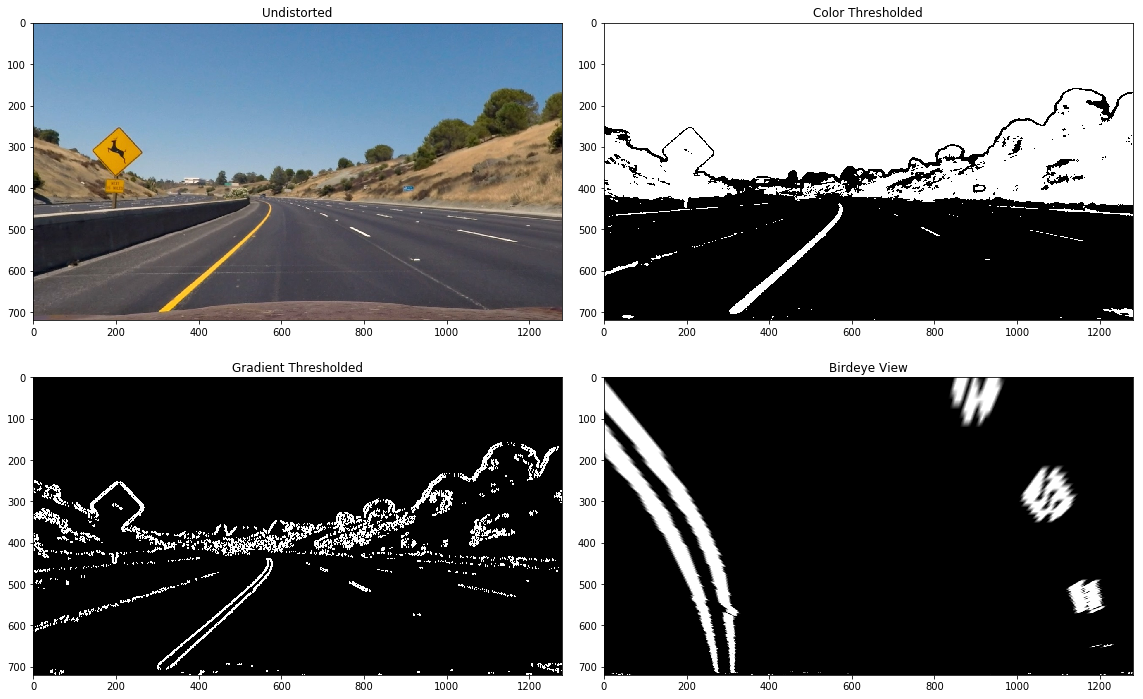

In [25]:
test2 = cv2.imread(os.path.join(test_data_dir, 'test2.jpg'), cv2.IMREAD_COLOR)
undistorted = cv2.undistort(test2, mtx, dist, None, mtx)
color_threshed = color_threshold(undistorted) * 255
gaus_blurred = gaussian_blur(color_threshed)
grad_threshed = combined_sobel_threshold(gaus_blurred)
binary_warped = cv2.warpPerspective(grad_threshed, M, (1280, 720), flags=cv2.INTER_LINEAR)
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
fig.tight_layout()
ax[0, 0].imshow(BGR_2_RGB(undistorted))
ax[0, 0].set_title('Undistorted')
ax[0, 1].imshow(color_threshed, 'gray')
ax[0, 1].set_title('Color Thresholded')
ax[1, 0].imshow(grad_threshed, 'gray')
ax[1, 0].set_title('Gradient Thresholded')
ax[1, 1].imshow(binary_warped, 'gray')
ax[1, 1].set_title('Birdeye View')

### Line detection

Find the peak location.

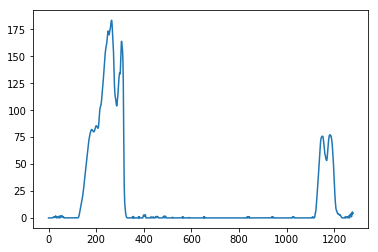

In [26]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

(719, 0)

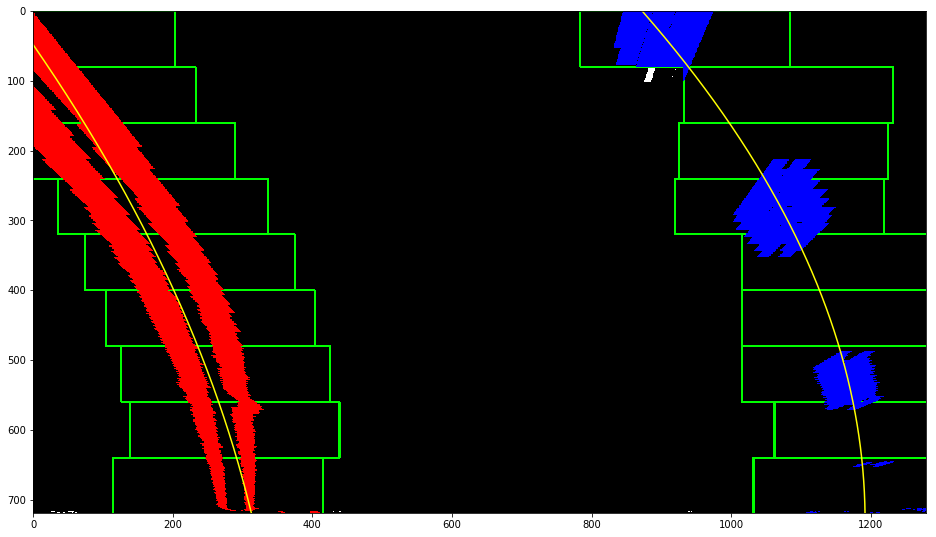

In [40]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped)).astype(np.uint8)*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 150
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(out_img)
ax.plot(left_fitx, ploty, color='yellow')
ax.plot(right_fitx, ploty, color='yellow')
ax.set_xlim(0, 1279)
ax.set_ylim(719, 0)

Detecting lane based on previous ploy-nomial curve.

(720, 0)

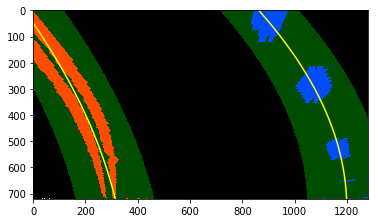

In [42]:
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 150
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                  left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                  left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                  right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                  right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped)).astype(np.uint8)*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)